In [0]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import os

D_PATH = '/content/drive/My Drive/Università/LaSapienza/Corsi/Visual Analytics/project'

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Download data from Kaggle
os.environ['KAGGLE_USERNAME'] = "mfabio" # username from the json file
os.environ['KAGGLE_KEY'] = "" # key from the json file
!kaggle datasets download -d taranvee/smart-home-dataset-with-weather-information # api copied from kaggle
!unzip -q smart-home-dataset-with-weather-information.zip
# !mv "training.1600000.processed.noemoticon.csv" "data.csv"
 
# data = pd.read_csv('data.csv', encoding='latin1', header = None, usecols=[0,5], names = ['label','tweet'])
# data.loc[data['label'] == 4, 'label'] = 1
# data = shuffle(data)

smart-home-dataset-with-weather-information.zip: Skipping, found more recently modified local copy (use --force to force download)
replace HomeC.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
data = pd.read_csv('HomeC.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (0,27) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
data.drop(data.tail(1).index, inplace=True)

Un riassunto dei dati, per cercare anomalie.

In [6]:
data.iloc[:,:9].describe()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW]
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.858962,0.076229,0.858962,0.031368,0.099210,0.136779,0.081287,0.063556
std,1.058207,0.128428,1.058207,0.190951,0.169059,0.178631,0.104466,0.076199
min,0.000000,0.000000,0.000000,0.000000,0.000017,0.000067,0.000083,0.000067
25%,0.367667,0.003367,0.367667,0.000000,0.020233,0.064400,0.040383,0.005083
50%,0.562333,0.004283,0.562333,0.000017,0.020617,0.066633,0.042217,0.005433
75%,0.970250,0.083917,0.970250,0.000233,0.068733,0.080633,0.068283,0.125417
max,14.714567,0.613883,14.714567,1.401767,1.934083,0.794933,0.971750,0.851267


In [7]:
data.iloc[:,9:18].describe()

,Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW]
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.042137,0.014139,0.002755,0.007023,0.000009,0.058530,0.015642,0.010983,0.035313
std,0.057967,0.014292,0.021860,0.076740,0.000010,0.202706,0.137841,0.098859,0.096056
min,0.000017,0.000017,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.007133,0.012733,0.000500,0.000017,0.000000,0.029833,0.000983,0.003617,0.001483
50%,0.008083,0.012933,0.000667,0.000050,0.000017,0.031317,0.001000,0.004000,0.001617
75%,0.053192,0.013100,0.000750,0.000167,0.000017,0.032883,0.001017,0.004067,0.001750
max,1.273933,1.088983,1.166583,2.262583,0.000183,7.027900,1.633017,1.929800,0.465217


In [8]:
data.iloc[:,18:27].describe()

,Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed
count,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000,503910.000000
mean,0.076229,50.741935,0.664085,9.253444,48.263382,1016.301625,6.649936
std,0.128428,19.113807,0.194389,1.611186,22.027916,7.895185,3.982716
min,0.000000,-12.640000,0.130000,0.270000,-32.080000,986.400000,0.000000
25%,0.003367,35.770000,0.510000,9.420000,31.090000,1011.290000,3.660000
50%,0.004283,50.320000,0.680000,10.000000,50.320000,1016.530000,5.930000
75%,0.083917,66.260000,0.840000,10.000000,66.260000,1021.480000,8.940000
max,0.613883,93.720000,0.980000,10.000000,101.120000,1042.460000,22.910000


In [9]:
data.iloc[:,27:36].describe()

,windBearing,precipIntensity,dewPoint,precipProbability
count,503910.000000,503910.000000,503910.000000,503910.000000
mean,202.356843,0.002598,38.694013,0.056453
std,106.520474,0.011257,19.087939,0.165836
min,0.000000,0.000000,-27.240000,0.000000
25%,148.000000,0.000000,24.600000,0.000000
50%,208.000000,0.000000,39.030000,0.000000
75%,295.000000,0.000000,54.790000,0.000000
max,359.000000,0.191000,75.490000,0.840000


Le colonne "use" e "House overall" hanno esattamente gli stessi dati.
Questo è vero anche per le colonne "solar" e "gen"

In [10]:
data['use [kW]'].equals(data['House overall [kW]'])

True

In [11]:
data['Solar [kW]'].equals(data['gen [kW]'])

True

I valori di totale consumo della casa sono diversi dalla somma dei singoli valori di tutti gli apparecchi che consumano. Inoltre non sempre il totale dei valori di consumo della casa è maggiore del totale dei singoli valori (quindi assumendo che ci siano altri dispositivi nella casa di cui non siamo a conoscenza). Circa un quarto della somma dei valori dei singoli dispositivi supera il valore totale dichiarato.  

In [12]:
data.iloc[:,4:18].sum(axis=1)

0         0.708017
1         0.711500
2         0.711550
3         0.803983
4         0.929017
            ...   
503905    0.835600
503906    0.836433
503907    1.167200
503908    1.223067
503909    1.235350
Length: 503910, dtype: float64

In [13]:
data['House overall [kW]'].equals(data.iloc[:,4:18].sum(axis=1))

False

In [0]:
df = pd.DataFrame()
df['overall'] = data['House overall [kW]']

In [0]:
df['sum'] = data.iloc[:,4:19].sum(axis=1)

In [16]:
df.head(20)

,overall,sum
0,0.932833,0.711500
1,0.934333,0.714967
2,0.931817,0.715017
3,1.022050,0.807467
4,1.139400,0.932483
5,1.391867,1.198283
6,1.366217,1.190617
7,1.431900,1.285033
8,1.627300,1.439033
9,1.735383,1.477350


In [17]:
df.loc[df['overall'] < df['sum']].count()

overall    129564
sum        129564
dtype: int64

In [18]:
df.count()

overall    503910
sum        503910
dtype: int64

Un occhio agli istogrammi per cercare di capire se c'è qualcosa di anomalo o outliers nei dati

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd49c2ef9b0>,
      dtype=object)

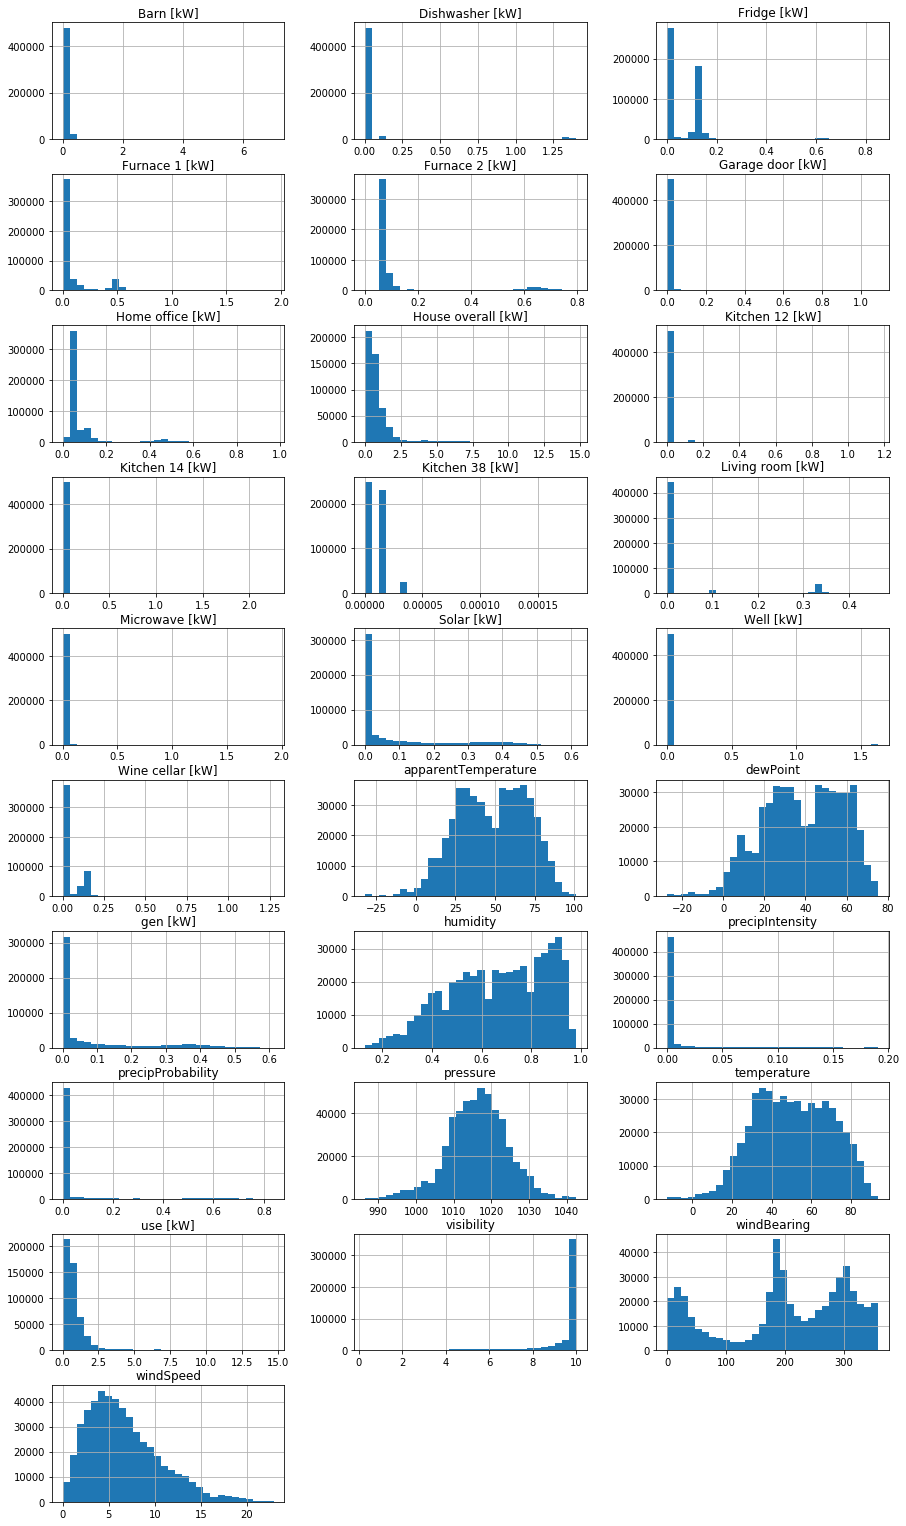

In [19]:
data.hist(bins=30, figsize=(15,30), layout=(11,3))

Ricerca dei NaN o di valori anomali

In [20]:
data.isin(['Nan']).any()

time                   False
use [kW]               False
gen [kW]               False
House overall [kW]     False
Dishwasher [kW]        False
Furnace 1 [kW]         False
Furnace 2 [kW]         False
Home office [kW]       False
Fridge [kW]            False
Wine cellar [kW]       False
Garage door [kW]       False
Kitchen 12 [kW]        False
Kitchen 14 [kW]        False
Kitchen 38 [kW]        False
Barn [kW]              False
Well [kW]              False
Microwave [kW]         False
Living room [kW]       False
Solar [kW]             False
temperature            False
icon                   False
humidity               False
visibility             False
summary                False
apparentTemperature    False
pressure               False
windSpeed              False
cloudCover             False
windBearing            False
precipIntensity        False
dewPoint               False
precipProbability      False
dtype: bool

In [21]:
data.dtypes

time                    object
use [kW]               float64
gen [kW]               float64
House overall [kW]     float64
Dishwasher [kW]        float64
Furnace 1 [kW]         float64
Furnace 2 [kW]         float64
Home office [kW]       float64
Fridge [kW]            float64
Wine cellar [kW]       float64
Garage door [kW]       float64
Kitchen 12 [kW]        float64
Kitchen 14 [kW]        float64
Kitchen 38 [kW]        float64
Barn [kW]              float64
Well [kW]              float64
Microwave [kW]         float64
Living room [kW]       float64
Solar [kW]             float64
temperature            float64
icon                    object
humidity               float64
visibility             float64
summary                 object
apparentTemperature    float64
pressure               float64
windSpeed              float64
cloudCover              object
windBearing            float64
precipIntensity        float64
dewPoint               float64
precipProbability      float64
dtype: o

La colonna CloudCover ha i primi 58 valori settati a 'cloudCover'. Li ho settati come None e cambiato tutta la colonna a float anziché mista. Da valutare se teneri i None o eliminare semplicemente i dati.

In [22]:
data.loc[data['cloudCover']  == 'cloudCover', ['cloudCover']]

,cloudCover
0,cloudCover
1,cloudCover
2,cloudCover
3,cloudCover
4,cloudCover
5,cloudCover
6,cloudCover
7,cloudCover
8,cloudCover
9,cloudCover


In [0]:
data.loc[data['cloudCover']  == 'cloudCover', ['cloudCover']] = None

In [24]:
data['cloudCover'] = data['cloudCover'].astype(float)
data['cloudCover'].unique()

array([ nan, 0.75, 0.  , 1.  , 0.31, 0.44, 0.13, 0.19, 0.25, 0.16, 0.21,
       0.15, 0.14, 0.27, 0.28, 0.17, 0.05, 0.1 , 0.26, 0.29, 0.11, 0.09,
       0.12, 0.06, 0.02, 0.08, 0.04, 0.35, 0.22, 0.23, 0.54, 0.39, 0.03,
       0.07, 0.76, 0.62, 0.18, 0.79, 0.48, 0.24, 0.57, 0.41, 0.78, 0.2 ,
       0.77, 0.46, 0.55, 0.01, 0.51, 0.47, 0.5 , 0.4 , 0.3 , 0.43, 0.33,
       0.6 , 0.68, 0.66, 0.45, 0.34, 0.52, 0.67, 0.49, 0.37, 0.36, 0.61,
       0.38, 0.42, 0.53, 0.63, 0.32, 0.56, 0.58, 0.72, 0.73, 0.71, 0.64,
       0.59])

In [25]:
len(data.loc[:, (data.dtypes == 'float64') | (data.dtypes == 'int64')].columns)

29

In [26]:
data.corr()

,use [kW],gen [kW],House overall [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],Solar [kW],temperature,humidity,visibility,apparentTemperature,pressure,windSpeed,cloudCover,windBearing,precipIntensity,dewPoint,precipProbability
use [kW],1.000000,-0.131635,1.000000,0.196272,0.314776,0.489414,0.147520,0.149223,0.124506,0.026531,0.048480,0.094211,0.049541,0.196339,0.157281,0.114817,0.200350,-0.131635,0.010379,0.011511,-0.002609,0.005560,0.010730,-0.003853,-0.033506,0.011183,0.024836,0.016040,-0.003317
gen [kW],-0.131635,1.000000,-0.131635,0.038204,-0.020461,-0.107684,-0.085421,-0.002862,0.062430,0.036328,-0.013871,-0.014468,0.035688,0.036456,0.025112,0.000375,-0.047849,1.000000,0.090983,0.007608,-0.017650,0.093793,-0.000222,-0.056554,0.000782,-0.007882,0.030447,0.089664,0.041192
House overall [kW],1.000000,-0.131635,1.000000,0.196272,0.314776,0.489414,0.147520,0.149223,0.124506,0.026531,0.048480,0.094211,0.049541,0.196339,0.157281,0.114817,0.200350,-0.131635,0.010379,0.011511,-0.002609,0.005560,0.010730,-0.003853,-0.033506,0.011183,0.024836,0.016040,-0.003317
Dishwasher [kW],0.196272,0.038204,0.196272,1.000000,0.002023,-0.008349,0.065525,0.034020,-0.004619,-0.008958,0.010258,0.000484,-0.000415,0.006914,0.008316,-0.001197,0.000612,0.038204,-0.015716,-0.001868,-0.008064,-0.014547,0.000211,-0.001672,-0.002361,0.004016,0.006265,-0.016099,0.008189
Furnace 1 [kW],0.314776,-0.020461,0.314776,0.002023,1.000000,0.240445,-0.019692,-0.042511,-0.096036,-0.022801,0.009976,0.011726,0.048717,-0.002904,0.019675,-0.001592,0.069186,-0.020461,-0.301663,-0.049854,-0.034729,-0.308621,-0.000283,0.092136,0.010399,0.025631,0.009164,-0.301091,0.000344
Furnace 2 [kW],0.489414,-0.107684,0.489414,-0.008349,0.240445,1.000000,-0.008555,-0.032574,-0.052272,0.002969,-0.006751,0.013790,0.140033,-0.003843,0.013121,0.000871,0.031664,-0.107684,-0.235567,-0.037408,-0.013126,-0.242814,-0.001532,0.072600,0.005556,0.031912,0.022545,-0.233404,0.007913
Home office [kW],0.147520,-0.085421,0.147520,0.065525,-0.019692,-0.008555,1.000000,0.035013,0.003896,-0.013537,-0.005123,0.009284,-0.001423,-0.038479,-0.006467,-0.007923,-0.052402,-0.085421,0.011908,-0.006008,0.020638,0.010856,0.027091,-0.017898,-0.040248,0.012427,-0.029890,0.007594,-0.032861
Fridge [kW],0.149223,-0.002862,0.149223,0.034020,-0.042511,-0.032574,0.035013,1.000000,0.076183,-0.002380,0.007725,0.009587,-0.009586,-0.002205,0.010579,0.025698,0.054008,-0.002862,0.107466,0.030749,0.009019,0.107064,-0.000517,-0.024886,-0.023428,-0.008589,0.014253,0.115169,0.004794
Wine cellar [kW],0.124506,0.062430,0.124506,-0.004619,-0.096036,-0.052272,0.003896,0.076183,1.000000,0.004393,0.022679,-0.001027,-0.012364,0.006372,0.006686,0.013267,0.033997,0.062430,0.289168,0.055541,0.030095,0.288882,0.018494,-0.052860,-0.040546,-0.025930,0.016588,0.298207,0.006571
Garage door [kW],0.026531,0.036328,0.026531,-0.008958,-0.022801,0.002969,-0.013537,-0.002380,0.004393,1.000000,0.000015,-0.000491,0.003120,0.017447,0.005698,-0.002093,0.004466,0.036328,0.013511,-0.007399,0.002262,0.013578,-0.000276,0.000419,-0.007443,0.012327,-0.006941,0.008350,-0.006639


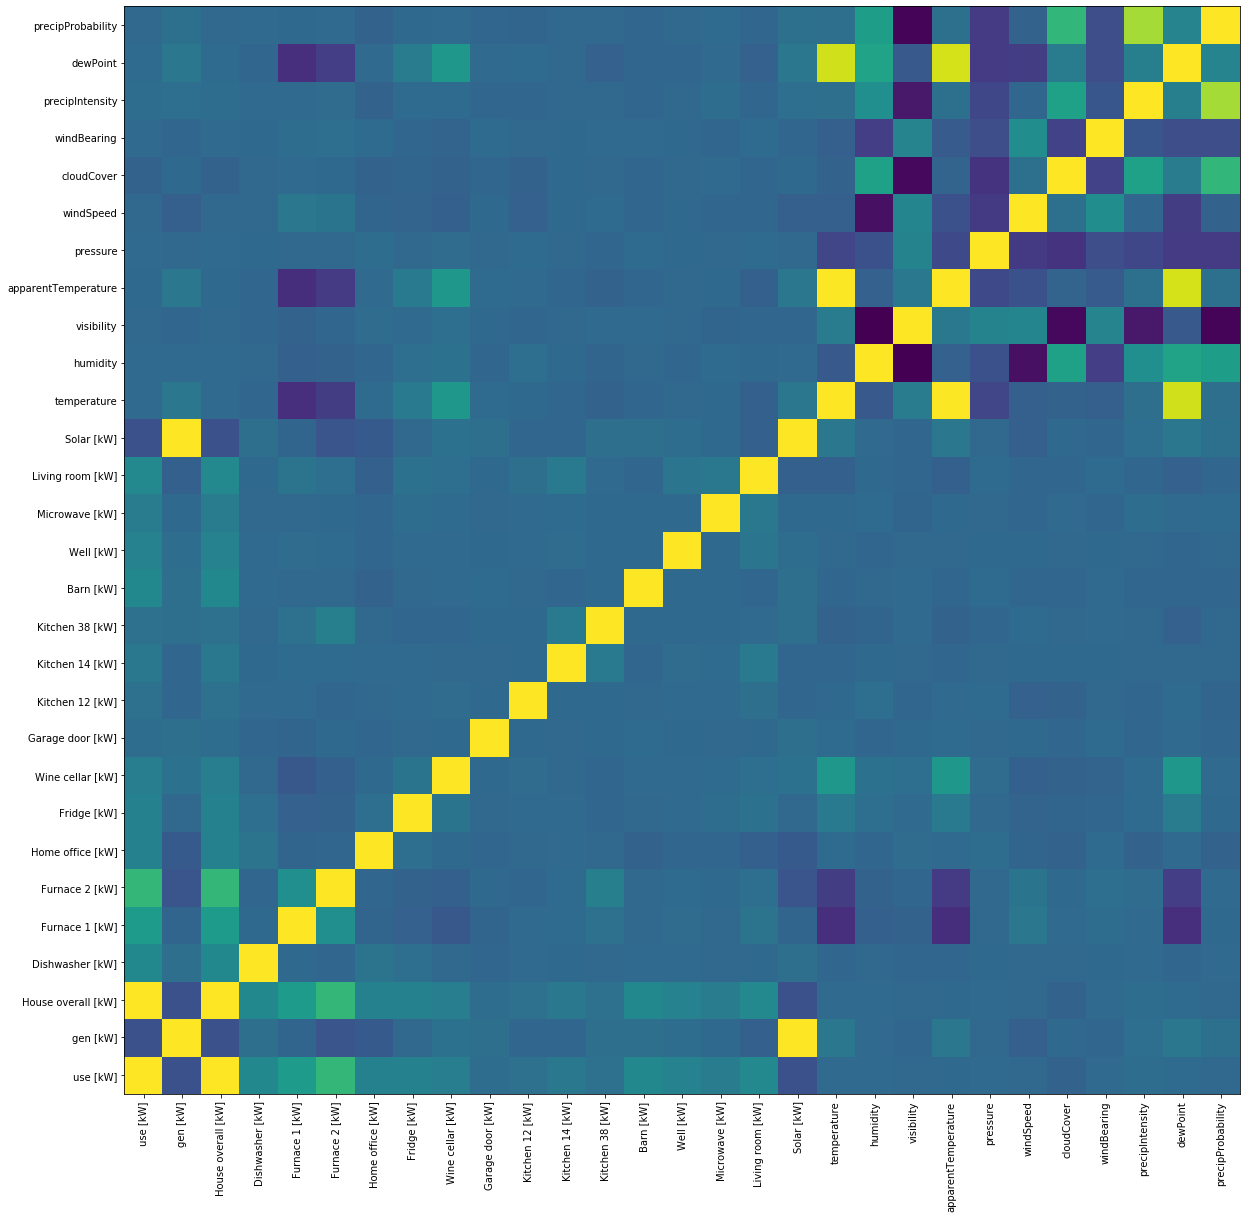

In [27]:
plt.figure(figsize = (20,20))

# sns.heatmap(data.corr(), annot=False, fmt="g", cmap='viridis')
# fig.show()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
labels = data.loc[:, (data.dtypes == 'float64') | (data.dtypes == 'int64')].columns
plt.pcolor(data.corr())
plt.yticks(np.arange(0.5, len(labels), 1), labels)
plt.xticks(np.arange(0.5, len(labels), 1), labels, rotation='vertical')
plt.show()

In [0]:
clean_data = data.copy()
clean_data = clean_data.iloc[58:,]
# clean_data['Furnace [kW]']  = clean_data['Furnace 1 [kW]'].values \
#                             + clean_data['Furnace 2 [kW]'].values
    
# clean_data['Kitchen [kW]']  = clean_data['Kitchen 38 [kW]'].values \
#                             + clean_data['Kitchen 14 [kW]'].values \
#                             + clean_data['Kitchen 12 [kW]'].values


# , \
#                                       'Furnace 2 [kW]', 'Furnace 1 [kW]', \
#                                       'Kitchen 12 [kW]', 'Kitchen 14 [kW]', 'Kitchen 38 [kW]', \
#                                       'windBearing','dewPoint','precipProbability', 'visibility',\

clean_data = clean_data.drop(columns=['House overall [kW]', 'Solar [kW]',\
                                      'use [kW]', 'apparentTemperature',\
                                      'summary', 'icon','cloudCover'])

clean_data['use [kW]'] = clean_data['Dishwasher [kW]'].values \
                        + clean_data['Home office [kW]'].values \
                        + clean_data['Fridge [kW]'].values \
                        + clean_data['Wine cellar [kW]'].values \
                        + clean_data['Barn [kW]'].values \
                        + clean_data['Well [kW]'].values \
                        + clean_data['Microwave [kW]'].values \
                        + clean_data['Living room [kW]'].values \
                        + clean_data['Furnace 1 [kW]'].values \
                        + clean_data['Furnace 2 [kW]'].values \
                        + clean_data['Kitchen 38 [kW]'].values \
                        + clean_data['Kitchen 14 [kW]'].values \
                        + clean_data['Kitchen 12 [kW]'].values \
                        + clean_data['Garage door [kW]'].values \

In [0]:
cols = clean_data.columns.tolist()
cols = [cols[0]] + cols[-3:] + cols[1:-3]

In [0]:
clean_data = clean_data[cols]

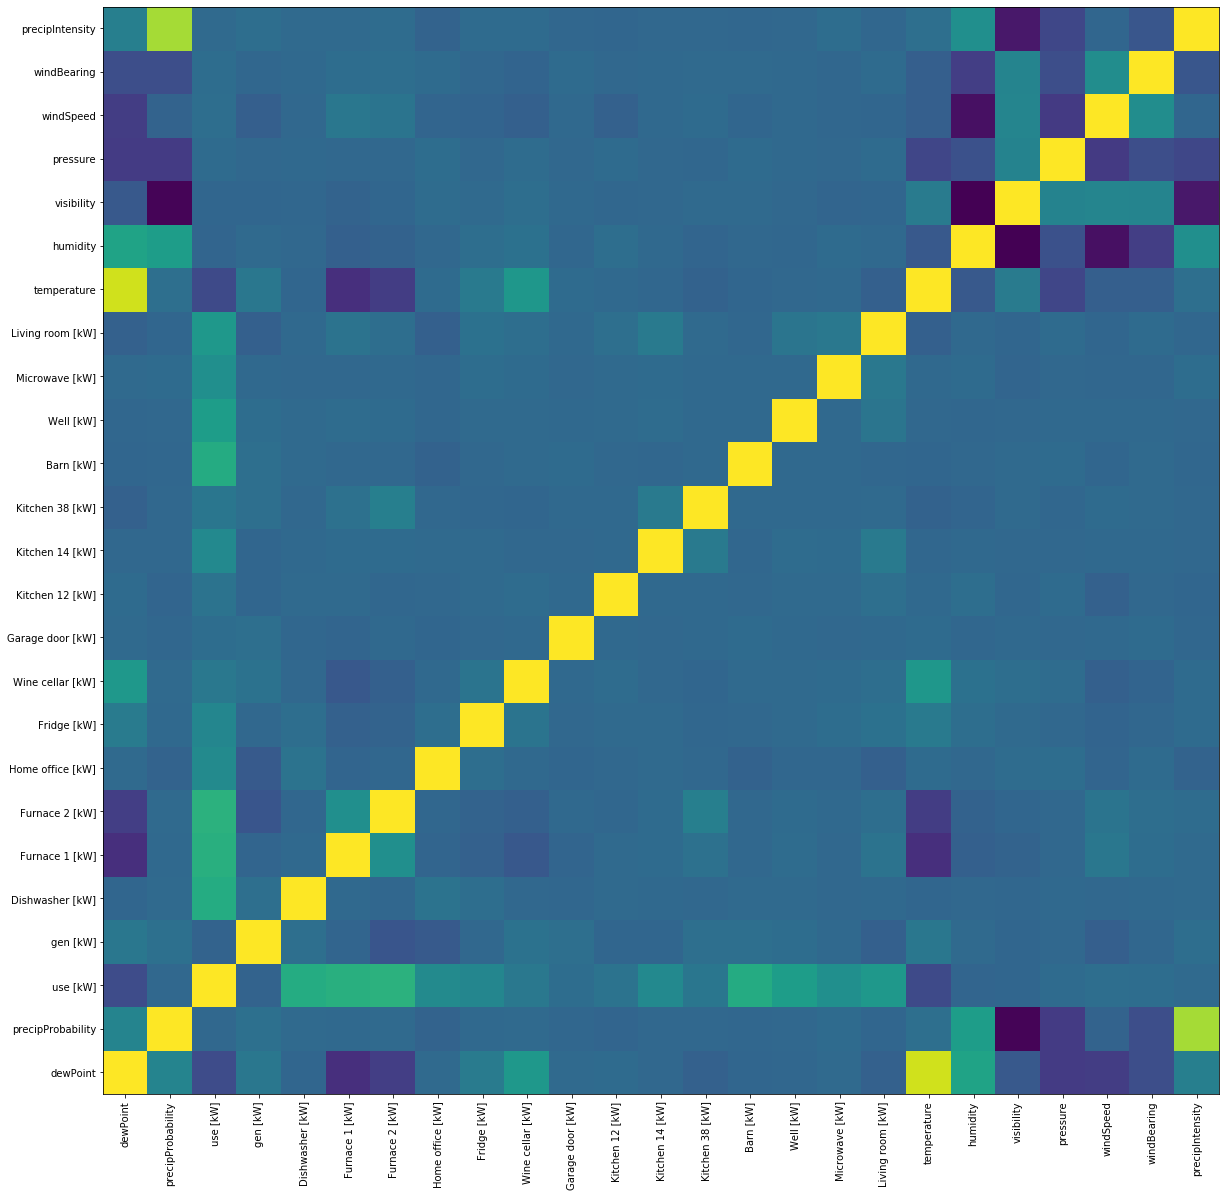

In [32]:
plt.figure(figsize = (20,20))

# sns.heatmap(data.corr(), annot=False, fmt="g", cmap='viridis')
# fig.show()
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
labels = clean_data.loc[:, (clean_data.dtypes == 'float64') | (clean_data.dtypes == 'int64')].columns
plt.pcolor(clean_data.corr())
plt.yticks(np.arange(0.5, len(labels), 1), labels)
plt.xticks(np.arange(0.5, len(labels), 1), labels, rotation='vertical')
plt.show()

In [33]:
lst = list(clean_data)
del lst[3]
lst

['time',
 'dewPoint',
 'precipProbability',
 'gen [kW]',
 'Dishwasher [kW]',
 'Furnace 1 [kW]',
 'Furnace 2 [kW]',
 'Home office [kW]',
 'Fridge [kW]',
 'Wine cellar [kW]',
 'Garage door [kW]',
 'Kitchen 12 [kW]',
 'Kitchen 14 [kW]',
 'Kitchen 38 [kW]',
 'Barn [kW]',
 'Well [kW]',
 'Microwave [kW]',
 'Living room [kW]',
 'temperature',
 'humidity',
 'visibility',
 'pressure',
 'windSpeed',
 'windBearing',
 'precipIntensity']

In [34]:
from datetime import datetime

clean_data['time_europe'] = [datetime.utcfromtimestamp(int(d)).strftime('%Y-%m-%d %H:%M:%S') for d in clean_data['time']]

time = np.array(range(int(datetime.timestamp(datetime.strptime('1/Jan/2016 00:00:00', '%d/%b/%Y %H:%M:%S'))), int(clean_data.loc[58,'time'])))
toadd = pd.DataFrame(time, columns = ['time'])
toadd['time_europe'] = [datetime.utcfromtimestamp(int(d)).strftime('%Y-%m-%d %H:%M:%S') for d in time]


for i in lst[1:]:
    toadd[i] = list(clean_data[i].sample(n=len(time), replace=True))
toadd['use [kW]'] = toadd.iloc[:,3:18].sum(axis=1)
final = pd.concat([toadd, clean_data], ignore_index=True)

print(clean_data.tail(1))
time = np.array(range(int(clean_data.iloc[-1,]['time'])+1, int(datetime.timestamp(datetime.strptime('8/Jan/2016 00:00:00', '%d/%b/%Y %H:%M:%S')))))
toadd = pd.DataFrame(time, columns = ['time'])
toadd['time_europe'] = [datetime.utcfromtimestamp(int(d)).strftime('%Y-%m-%d %H:%M:%S') for d in time]
for i in lst[1:]:
    toadd[i] = list(clean_data[i].sample(n=len(time), replace=True))
toadd['use [kW]'] = toadd.iloc[:,3:18].sum(axis=1)
final = pd.concat([final,toadd], ignore_index=True)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]


              time  dewPoint  ...  precipIntensity          time_europe
503909  1452128309     31.27  ...           0.0101  2016-01-07 00:58:29

[1 rows x 27 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [35]:
final_filtered = final.iloc[::60, :]
final_filtered.shape

(10080, 27)

In [36]:
final_filtered.head()

,Barn [kW],Dishwasher [kW],Fridge [kW],Furnace 1 [kW],Furnace 2 [kW],Garage door [kW],Home office [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Living room [kW],Microwave [kW],Well [kW],Wine cellar [kW],dewPoint,gen [kW],humidity,precipIntensity,precipProbability,pressure,temperature,time,time_europe,use [kW],visibility,windBearing,windSpeed
0,0.031300,0.000000,0.005000,0.021000,0.063650,0.012967,0.041633,0.000683,0.000050,0.000017,0.001700,0.003167,0.001017,0.007600,54.08,0.003350,0.33,0.0000,0.0,1015.86,42.42,1451606400,2016-01-01 00:00:00,0.191433,2.45,280.0,2.88
60,0.033417,0.000000,0.005050,0.492133,0.064850,0.012550,0.041917,0.000750,0.000067,0.000000,0.001417,0.002917,0.001050,0.008083,63.16,0.053650,0.79,0.0018,0.0,1018.76,60.73,1451606460,2016-01-01 00:01:00,0.716433,0.84,9.0,1.36
120,0.032383,0.000000,0.005183,0.020600,0.066300,0.012883,0.164567,0.000733,0.000017,0.000017,0.001567,0.003167,0.001000,0.006883,19.75,0.245200,0.54,0.0000,0.0,1020.43,53.25,1451606520,2016-01-01 00:02:00,0.558933,10.00,307.0,1.62
180,0.030183,0.000050,0.133017,0.020500,0.552967,0.012717,0.092100,0.000667,0.000017,0.000017,0.094617,0.004050,0.001000,0.014583,67.53,0.001433,0.90,0.0000,0.0,1007.48,79.97,1451606580,2016-01-01 00:03:00,0.863300,8.62,190.0,4.33
240,0.031600,0.000017,0.129333,0.020217,0.066183,0.012333,0.102333,0.000650,0.000067,0.000017,0.001650,0.004200,0.000917,0.008333,25.00,0.435617,0.70,0.0000,0.0,1020.61,32.47,1451606640,2016-01-01 00:04:00,0.811817,10.00,286.0,3.64


In [0]:
final_filtered.to_csv('clean_dataset.csv', sep=',', index = False)

In [0]:
# final_filtered = pd.read_csv(D_PATH +'/clean_dataset.csv', sep=',')

In [39]:
final_filtered.head()

,Barn [kW],Dishwasher [kW],Fridge [kW],Furnace 1 [kW],Furnace 2 [kW],Garage door [kW],Home office [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Living room [kW],Microwave [kW],Well [kW],Wine cellar [kW],dewPoint,gen [kW],humidity,precipIntensity,precipProbability,pressure,temperature,time,time_europe,use [kW],visibility,windBearing,windSpeed
0,0.031300,0.000000,0.005000,0.021000,0.063650,0.012967,0.041633,0.000683,0.000050,0.000017,0.001700,0.003167,0.001017,0.007600,54.08,0.003350,0.33,0.0000,0.0,1015.86,42.42,1451606400,2016-01-01 00:00:00,0.191433,2.45,280.0,2.88
60,0.033417,0.000000,0.005050,0.492133,0.064850,0.012550,0.041917,0.000750,0.000067,0.000000,0.001417,0.002917,0.001050,0.008083,63.16,0.053650,0.79,0.0018,0.0,1018.76,60.73,1451606460,2016-01-01 00:01:00,0.716433,0.84,9.0,1.36
120,0.032383,0.000000,0.005183,0.020600,0.066300,0.012883,0.164567,0.000733,0.000017,0.000017,0.001567,0.003167,0.001000,0.006883,19.75,0.245200,0.54,0.0000,0.0,1020.43,53.25,1451606520,2016-01-01 00:02:00,0.558933,10.00,307.0,1.62
180,0.030183,0.000050,0.133017,0.020500,0.552967,0.012717,0.092100,0.000667,0.000017,0.000017,0.094617,0.004050,0.001000,0.014583,67.53,0.001433,0.90,0.0000,0.0,1007.48,79.97,1451606580,2016-01-01 00:03:00,0.863300,8.62,190.0,4.33
240,0.031600,0.000017,0.129333,0.020217,0.066183,0.012333,0.102333,0.000650,0.000067,0.000017,0.001650,0.004200,0.000917,0.008333,25.00,0.435617,0.70,0.0000,0.0,1020.61,32.47,1451606640,2016-01-01 00:04:00,0.811817,10.00,286.0,3.64


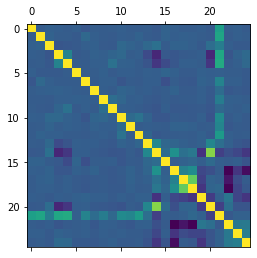

In [40]:
dataset = pd.read_csv('clean_dataset.csv')
dataset = dataset.drop('time', axis=1)
dataset = dataset.drop('time_europe', axis=1)
# dataset.rename(columns={
#                         'Dishwasher [kW]':'D',
#                         'Furnace 1 [kW]':'F1',
#                         'Furnace 2 [kW]':'F2',
#                         'Home office [kW]':'HO',
#                         'Fridge [kW]':'F',
#                         'Wine cellar [kW]':'WC',
#                         'Garage door [kW]':'GD',
#                         'Kitchen 12 [kW]':'K1',
#                         'Kitchen 14 [kW]':'K2',
#                         'Kitchen 38 [kW]':'K3',
#                         'Barn [kW]':'B',
#                         'Well [kW]':'W',
#                         'Microwave [kW]':'M',
#                         'Living room [kW]':'LR'}, 
#                  inplace=True)

corrMatrix = dataset.corr(method= 'pearson')
plt.matshow(corrMatrix)
plt.show()

corrMatrix.to_csv("correlation_m2.csv", sep=',', quoting=csv.QUOTE_NONNUMERIC)
#print (corrMatrix)

PCA test

In [41]:
clean_data.iloc[:,11:16]

,Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW]
58,0.013183,0.000667,0.000050,0.000017,0.031750
59,0.012883,0.000750,0.000067,0.000017,0.031783
60,0.012950,0.000717,0.000083,0.000017,0.031800
61,0.012883,0.000733,0.000083,0.000017,0.031817
62,0.012917,0.000467,0.000033,0.000000,0.031800
...,...,...,...,...,...
503905,0.013483,0.000467,0.000150,0.000017,0.032283
503906,0.013433,0.000467,0.000100,0.000033,0.032200
503907,0.012933,0.000533,0.000067,0.000000,0.032283
503908,0.012817,0.000517,0.000117,0.000017,0.032183


In [0]:
final_filtered = final_filtered.drop(['time', 'time_europe'], axis = 1)

In [43]:
final_filtered.iloc[:,16:]

,humidity,precipIntensity,precipProbability,pressure,temperature,use [kW],visibility,windBearing,windSpeed
0,0.33,0.0000,0.0,1015.86,42.42,0.191433,2.45,280.0,2.88
60,0.79,0.0018,0.0,1018.76,60.73,0.716433,0.84,9.0,1.36
120,0.54,0.0000,0.0,1020.43,53.25,0.558933,10.00,307.0,1.62
180,0.90,0.0000,0.0,1007.48,79.97,0.863300,8.62,190.0,4.33
240,0.70,0.0000,0.0,1020.61,32.47,0.811817,10.00,286.0,3.64
...,...,...,...,...,...,...,...,...,...
604500,0.66,0.0000,0.0,1022.80,27.61,0.201250,10.00,346.0,9.85
604560,0.36,0.0000,0.0,999.53,68.21,0.260633,10.00,41.0,3.24
604620,0.24,0.0000,0.0,1008.57,39.21,0.553867,9.61,163.0,3.55
604680,0.43,0.0000,0.0,1030.09,23.37,0.611817,9.87,34.0,5.84


In [0]:
final_filtered = final_filtered[['Barn [kW]','Dishwasher [kW]','Fridge [kW]','Furnace 1 [kW]','Furnace 2 [kW]','Garage door [kW]','Home office [kW]','Kitchen 12 [kW]','Kitchen 14 [kW]','Kitchen 38 [kW]','Living room [kW]','Microwave [kW]','Well [kW]','Wine cellar [kW]','gen [kW]','use [kW]','dewPoint','humidity','precipIntensity','precipProbability','pressure','temperature','visibility','windBearing','windSpeed']]

In [0]:
# Standardizing the features
import matplotlib.pyplot as plt

clean_data_np = StandardScaler().fit_transform(final_filtered.iloc[:,16:])

In [46]:
np.count_nonzero(np.isnan(clean_data_np))

0

In [0]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(clean_data_np)
principalDf = pd.DataFrame(data = principalComponents, columns = ['principal component 1', 'principal component 2'])

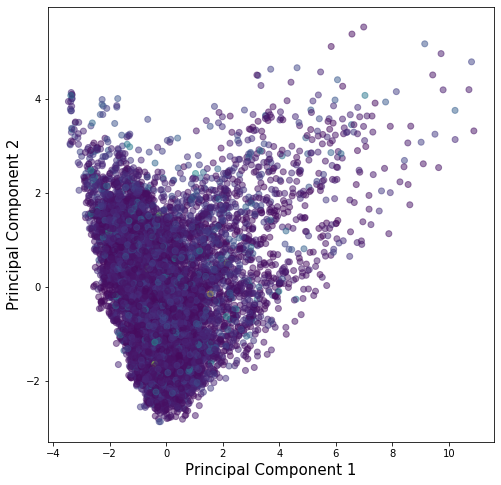

In [48]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
plt.scatter(principalComponents.T[0],principalComponents.T[1], c=final_filtered['use [kW]'], alpha=0.5)
plt.show()
ax.grid()

In [49]:
clean_data

,time,dewPoint,precipProbability,use [kW],gen [kW],Dishwasher [kW],Furnace 1 [kW],Furnace 2 [kW],Home office [kW],Fridge [kW],Wine cellar [kW],Garage door [kW],Kitchen 12 [kW],Kitchen 14 [kW],Kitchen 38 [kW],Barn [kW],Well [kW],Microwave [kW],Living room [kW],temperature,humidity,visibility,pressure,windSpeed,windBearing,precipIntensity,time_europe
58,1451624458,23.90,0.00,0.555183,0.003417,0.000033,0.021083,0.309983,0.043067,0.005167,0.123317,0.013183,0.000667,0.000050,0.000017,0.031750,0.001000,0.004233,0.001633,35.87,0.61,10.00,1016.25,8.29,285.0,0.0000,2016-01-01 05:00:58
59,1451624459,23.90,0.00,0.383883,0.003417,0.000017,0.096983,0.062867,0.043283,0.005000,0.123283,0.012883,0.000750,0.000067,0.000017,0.031783,0.001017,0.004233,0.001700,35.87,0.61,10.00,1016.25,8.29,285.0,0.0000,2016-01-01 05:00:59
60,1451624460,23.90,0.00,0.351200,0.003450,0.000017,0.064500,0.062633,0.043250,0.005017,0.123350,0.012950,0.000717,0.000083,0.000017,0.031800,0.001000,0.004233,0.001633,35.87,0.61,10.00,1016.25,8.29,285.0,0.0000,2016-01-01 05:01:00
61,1451624461,23.90,0.00,0.399833,0.003417,0.000017,0.111333,0.063883,0.043300,0.004967,0.123867,0.012883,0.000733,0.000083,0.000017,0.031817,0.001017,0.004233,0.001683,35.87,0.61,10.00,1016.25,8.29,285.0,0.0000,2016-01-01 05:01:01
62,1451624462,23.90,0.00,0.511633,0.003417,0.000017,0.114583,0.063200,0.043283,0.114167,0.124267,0.012917,0.000467,0.000033,0.000000,0.031800,0.001000,0.004233,0.001667,35.87,0.61,10.00,1016.25,8.29,285.0,0.0000,2016-01-01 05:01:02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503905,1452128305,31.27,0.51,0.835600,0.003183,0.000050,0.085267,0.642417,0.041783,0.005267,0.008667,0.013483,0.000467,0.000150,0.000017,0.032283,0.000983,0.003800,0.000967,35.12,0.86,8.74,1011.49,6.72,186.0,0.0101,2016-01-07 00:58:25
503906,1452128306,31.27,0.51,0.836433,0.003233,0.000050,0.104017,0.625033,0.041750,0.005233,0.008433,0.013433,0.000467,0.000100,0.000033,0.032200,0.000950,0.003800,0.000933,35.12,0.86,8.74,1011.49,6.72,186.0,0.0101,2016-01-07 00:58:26
503907,1452128307,31.27,0.51,1.167200,0.003217,0.000033,0.422383,0.637733,0.042033,0.004983,0.008467,0.012933,0.000533,0.000067,0.000000,0.032283,0.001000,0.003750,0.001000,35.12,0.86,8.74,1011.49,6.72,186.0,0.0101,2016-01-07 00:58:27
503908,1452128308,31.27,0.51,1.223067,0.003217,0.000050,0.495667,0.620367,0.042100,0.005333,0.008233,0.012817,0.000517,0.000117,0.000017,0.032183,0.000950,0.003767,0.000950,35.12,0.86,8.74,1011.49,6.72,186.0,0.0101,2016-01-07 00:58:28


In [50]:
sum(pca.explained_variance_ratio_)

0.466363592166128

In [51]:
pca.components_[0]

array([ 0.34206038,  0.41343069,  0.41847338,  0.46267719, -0.19829276,
        0.18197608, -0.40807753, -0.20319941, -0.20646313])

In [52]:
final_filtered.iloc[:,16:].columns

Index(['dewPoint', 'humidity', 'precipIntensity', 'precipProbability',
       'pressure', 'temperature', 'visibility', 'windBearing', 'windSpeed'],
      dtype='object')

In [0]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, n_iter=10000).fit_transform(clean_data_np)
# X_embedded.shape

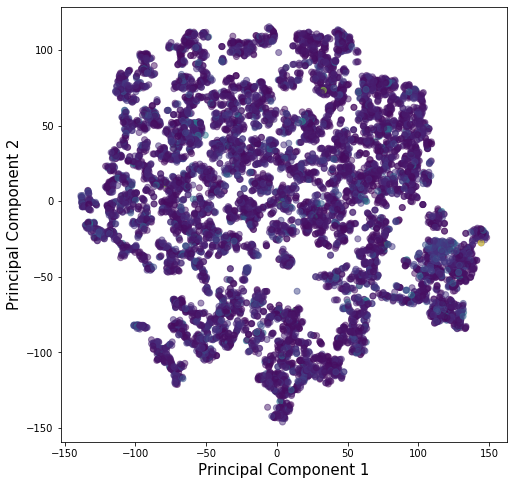

In [54]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
plt.scatter(X_embedded.T[0], X_embedded.T[1], c=final_filtered['use [kW]'], alpha=0.5)
plt.show()
ax.grid()

In [55]:
principalDf['principal component 1']

0        1.025803
1        3.336298
2       -1.063685
3        1.567949
4       -0.897897
           ...   
10075   -1.115369
10076    0.413331
10077   -1.591942
10078   -1.958867
10079   -0.253780
Name: principal component 1, Length: 10080, dtype: float64

In [0]:
f1 = pd.DataFrame(np.array([principalDf['principal component 1'], principalDf['principal component 2'], final_filtered['use [kW]']]).T, columns=['PC1', 'PC2', 'use'])

In [0]:
f2 = pd.DataFrame(np.array([X_embedded.T[0], X_embedded.T[1], final_filtered['use [kW]']]).T, columns=['PC1', 'PC2', 'use'])

In [58]:
f2.head()

,PC1,PC2,use
0,39.335423,-50.224068,0.191433
1,63.643581,-78.766510,0.716433
2,-12.642354,49.780113,0.558933
3,97.284615,9.302309,0.863300
4,-56.744450,-8.826795,0.811817


In [0]:
f2.to_csv('tsne.csv', sep=',', header=True, index=False)

In [0]:
f1.to_csv('pca.csv', sep=',', header=True, index=False)